In [297]:
from collections import Counter, defaultdict
from itertools import combinations

import Levenshtein
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from Bio import pairwise2
from Bio.Align import substitution_matrices
from tqdm import tqdm, trange

In [247]:
extended_iupac_protein_alphabet = set('ACDEFGHIKLMNPQRSTVWYBXZJUO')

In [407]:
def clean_data(data: pd.DataFrame, tcr_col: str, pep_col: str) -> pd.DataFrame:
    print(f'Raw data size = {len(data):,}')

    data = data[data[tcr_col].notna() & data[pep_col].notna()]
    data = data.drop_duplicates([tcr_col, pep_col])
    data = data[[all(aa in extended_iupac_protein_alphabet for aa in peptide) for peptide in data[pep_col]]]
    data[tcr_col] = [tcr.split('+')[0] for tcr in data[tcr_col]]  # extract CDR3 for ImmuneCODE dataset
    data = data[[8 <= len(peptide) <= 11 for peptide in data[pep_col]]]  # enforce peptide length constraint
    data = data[[6 <= len(tcr) <= 23 for tcr in data[tcr_col]]]  # enforce TCR length constraint

    print(f'Clean data size = {len(data):,}')

    return data

In [356]:
ALL_METADATA = {
    'vdjdb': {
        'path': '../../data/databases/vdjdb.tsv',
        'sep': '\t',
        'tcr_col': 'CDR3',
        'pep_col': 'Epitope',
        'gene_col': 'Gene'
    },
    'mcpas': {
        'path': '../../data/databases/McPAS-TCR.csv',
        'sep': ',',
        'tcr_col': 'CDR3.beta.aa',
        'pep_col': 'Epitope.peptide'
    },
    'iedb_positive': {
        'path': '../../data/databases/iedb_positive.csv',
        'sep': ',',
        'tcr_col': 'Chain 2 CDR3 Calculated',
        'pep_col': 'Description'
    },
    'immune_code': {
        'path': '../../data/databases/immuneCODE/ImmuneCODE-MIRA-Release002.1/peptide-detail-ci.csv',
        'sep': ',',
        'tcr_col': 'TCR BioIdentity',
        'pep_col': 'Amino Acids'
    }
}

In [453]:
datasets = [
#     'vdjdb',
#     'mcpas',
#     'iedb_positive',
    'immune_code'
]

In [454]:
tcr_peptide_pairs = set()
for dataset in datasets:
    print(dataset)
    metadata = ALL_METADATA[dataset]

    data = pd.read_csv(metadata['path'], sep=metadata['sep'])

    if 'gene_col' in metadata:
        data = data[data[metadata['gene_col']] == 'TRB']

    data = clean_data(data, tcr_col=metadata['tcr_col'], pep_col=metadata['pep_col'])

    tcr_peptide_pairs |= set(zip(data[metadata['tcr_col']], data[metadata['pep_col']]))
    print()

tcr_peptide_pairs = sorted(tcr_peptide_pairs)

immune_code
Raw data size = 154,320
Clean data size = 48,774



In [455]:
peptides = sorted({tcr_peptide[1] for tcr_peptide in tcr_peptide_pairs})
print(f'Num unique peptides = {len(peptides):,}')

Num unique peptides = 137


Text(0, 0.5, 'Count')

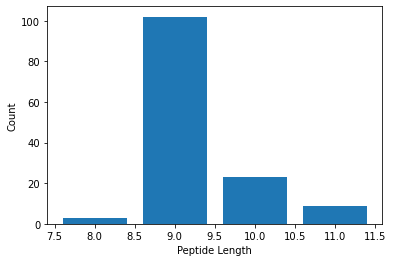

In [456]:
plt.bar(*zip(*Counter([len(peptide) for peptide in peptides]).most_common()))
plt.xlabel('Peptide Length')
plt.ylabel('Count')

In [457]:
tcrs = sorted({tcr_peptide[0] for tcr_peptide in tcr_peptide_pairs})
print(f'Num unique TCRs = {len(tcrs):,}')

Num unique TCRs = 47,306


Text(0, 0.5, 'Count')

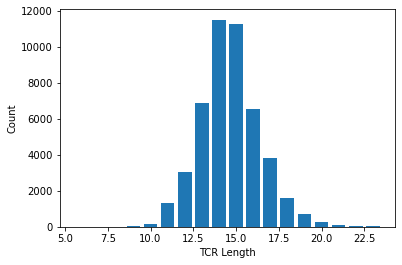

In [458]:
plt.bar(*zip(*Counter([len(tcr) for tcr in tcrs]).most_common()))
plt.xlabel('TCR Length')
plt.ylabel('Count')

In [459]:
print(f'Num unique TCR-peptide pairs = {len(tcr_peptide_pairs):,}')

Num unique TCR-peptide pairs = 48,061


In [460]:
peptide_to_tcr = defaultdict(set)
tcr_to_peptide = defaultdict(set)

for tcr, peptide in tcr_peptide_pairs:
    peptide_to_tcr[peptide].add(tcr)
    tcr_to_peptide[tcr].add(peptide)

In [461]:
tcr_counts_per_peptide = Counter([len(tcrs) for tcrs in peptide_to_tcr.values()])
print(f'Num peptides with > 1 TCRs: {len(peptides) - tcr_counts_per_peptide[1]:,}\n')
for tcr_count in sorted(tcr_counts_per_peptide)[:5]:
    print(f'Num peptides with {tcr_count:,} TCRs: {tcr_counts_per_peptide[tcr_count]:,}')
print('...')

Num peptides with > 1 TCRs: 137

Num peptides with 2 TCRs: 2
Num peptides with 3 TCRs: 2
Num peptides with 4 TCRs: 3
Num peptides with 5 TCRs: 6
Num peptides with 6 TCRs: 2
...


In [462]:
peptide_counts_per_tcr = Counter([len(peptides) for peptides in tcr_to_peptide.values()])
print(f'Num TCRs with > 1 peptides: {len(tcrs) - peptide_counts_per_tcr[1]:,}\n')
for peptide_count in sorted(peptide_counts_per_tcr)[:5]:
    print(f'Num TCRs with {peptide_count:,} peptides: {peptide_counts_per_tcr[peptide_count]:,}')
print('...')

Num TCRs with > 1 peptides: 623

Num TCRs with 1 peptides: 46,683
Num TCRs with 2 peptides: 543
Num TCRs with 3 peptides: 60
Num TCRs with 4 peptides: 12
Num TCRs with 5 peptides: 4
...


In [463]:
unique_peptide_pairs = sorted({
    tuple(sorted(peptide_pair))
    for peptides in tcr_to_peptide.values()
    for peptide_pair in combinations(peptides, 2)
})
print(f'Number of unique peptide pairs shared across a TCR = {len(unique_peptide_pairs):,}')

Number of unique peptide pairs shared across a TCR = 648


In [464]:
scoring = substitution_matrices.load("BLOSUM62")
gap_open = -5.0
gap_extend = -0.5

In [465]:
peptide_pair_scores = []
peptide_pair_dists = []
for pep_1, pep_2 in tqdm(unique_peptide_pairs):
    peptide_pair_scores.append(pairwise2.align.globalds(pep_1, pep_2, scoring, gap_open, gap_extend, score_only=True))
    peptide_pair_dists.append(Levenshtein.distance(pep_1, pep_2))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:02<00:00, 240.12it/s]


Text(0, 0.5, 'Count')

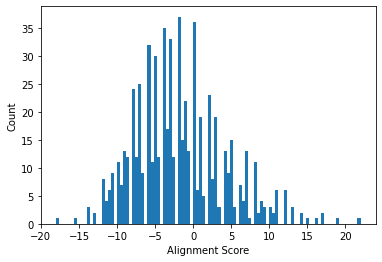

In [466]:
plt.hist(peptide_pair_scores, bins=100)
plt.xlabel('Alignment Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

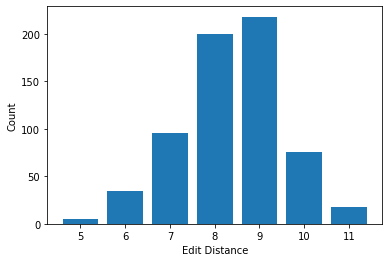

In [467]:
plt.bar(*zip(*Counter(peptide_pair_dists).most_common()))
plt.xlabel('Edit Distance')
plt.ylabel('Count')

Text(0, 0.5, 'Aligment Score')

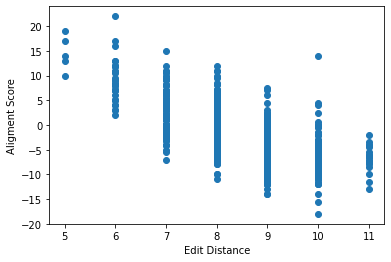

In [468]:
plt.scatter(peptide_pair_dists, peptide_pair_scores)
plt.xlabel('Edit Distance')
plt.ylabel('Aligment Score')

In [448]:
num_peptides = len(peptides)  # 100
scores = np.zeros((num_peptides, num_peptides))
distances = np.zeros((num_peptides, num_peptides))

# Randomly sample
if num_peptides < len(peptides):
    print(f'Sampling {num_peptides:,} peptides')
    rng = np.random.default_rng(seed=0)
    peptides = sorted(rng.choice(peptides, size=num_peptides, replace=False))

for i in trange(num_peptides):
    for j in range(i + 1, num_peptides):
#         scores[i, j] = pairwise2.align.globalds(peptides[i], peptides[j], scoring, gap_open, gap_extend, score_only=True)
        distances[i, j] = Levenshtein.distance(peptides[i], peptides[j])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1614/1614 [00:00<00:00, 2194.41it/s]


In [449]:
scores_flat = [scores[i, j] for i in range(num_peptides) for j in range(i + 1, num_peptides)]
distances_flat = [distances[i, j] for i in range(num_peptides) for j in range(i + 1, num_peptides)]

Text(0, 0.5, 'Count')

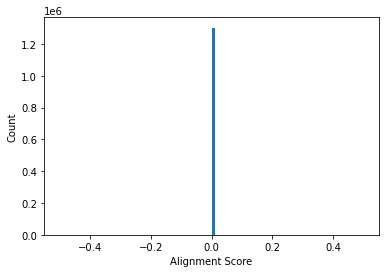

In [450]:
plt.hist(scores_flat, bins=100)
plt.xlabel('Alignment Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

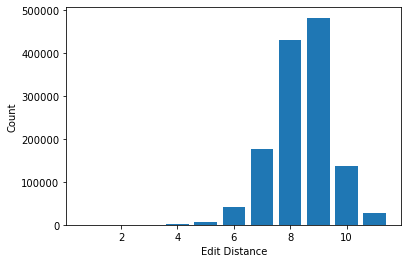

In [451]:
plt.bar(*zip(*Counter(distances_flat).most_common()))
plt.xlabel('Edit Distance')
plt.ylabel('Count')

In [268]:
mean = np.mean(scores_flat)
std = np.std(scores_flat)
print(f'Scores = {mean:.2f} +/- {std:.2f}')

threshold = mean + 3 * std
print(f'Threshold = mean + 3 * std = {threshold}')

I, J = np.where(scores > threshold)

Scores = -2.66 +/- 5.41
Threshold = mean + 3 * std = 13.5820738484585


In [269]:
for i, j in zip(I, J):
    print(peptides[i], peptides[j])

ALSKGVHFV KLNVGDYFV
ALSKGVHFV KLSYGIATV
ALWEIQQVV FTYASALWEI
AYILFTRFFYV YIFFASFYY
DSFKEELDKY FVFKNIDGY
FADDLNQLTGY FTEQPIDLVPNQPY
FADDLNQLTGY FVFKNIDGY
FADDLNQLTGY HTDFSSEIIGY
FADDLNQLTGY LSDDAVVCFNSTY
FIAGLIAIV FVDGVPFVV
FLGRYMSAL FLNRFTTTL
FLGRYMSAL FLPRVFSAV
FLGRYMSAL FRYMNSQGL
FLGRYMSAL HTTDPSFLGRY
FLNGSCGSV TLIGDCATV
FLNRFTTTL VVYRGTTTY
FLNRFTTTL YLNTLTLAV
FLPRVFSAV LPQGFSAL
FPPTSFGPL YEGNSPFHPL
FQPTNGVGY YFPLQSYGF
FRYMNSQGL FVFKNIDGY
FTEQPIDLVPNQPY ITEEVGHTDLMAAY
FVDGVPFVV IVDTVSALV
GSFCTQLNR GTHWFVTQR
GTGPEAGLPY SEVGPEHSLAEY
GTHWFVTQR REGVFVSNGTHW
GTITVEELK RIFTIGTVTLK
HTDFSSEIIGY HTTDPSFLGRY
HTDFSSEIIGY RVDFCGKGY
IITTDNTFV LVLSVNPYV
ILHCANFNV MLWCKDGHV
ILPDPSKPSK TVYDPLQPELDSFK
ITEEVGHTDLMAAY SEVGPEHSLAEY
IVDTVSALV VLQAVGACV
KLFAAETLK RIFTIGTVTLK
KLFAAETLK RLFRKSNLK
KLNVGDYFV RYRIGNYKL
KLWAQCVQL NLWNTFTRL
KLWAQCVQL VLWAHGFEL
LAAVYRINWI LLALHRSYL
LDYIINLII LEPLVDLPI
LDYIINLII YLDAYNMMI
LLFNKVTLA RLFRKSNLK
LMIERFVSL MMISAGFSL
LPAADLDDF LPPAYTNSF
LPNNTASWF MPASWVMRI
LQLGFSTGV TQL

In [270]:
graph = nx.Graph()
graph.add_nodes_from(peptides[:num_peptides])
for i, j in zip(I, J):
    graph.add_edge(peptides[i], peptides[j])

In [271]:
components = [sorted(component) for component in sorted(nx.connected_components(graph), key=len, reverse=True) if len(component) > 1]
connected_peptides = [peptide for component in components for peptide in component]
connnected_graph = graph.subgraph(connected_peptides)

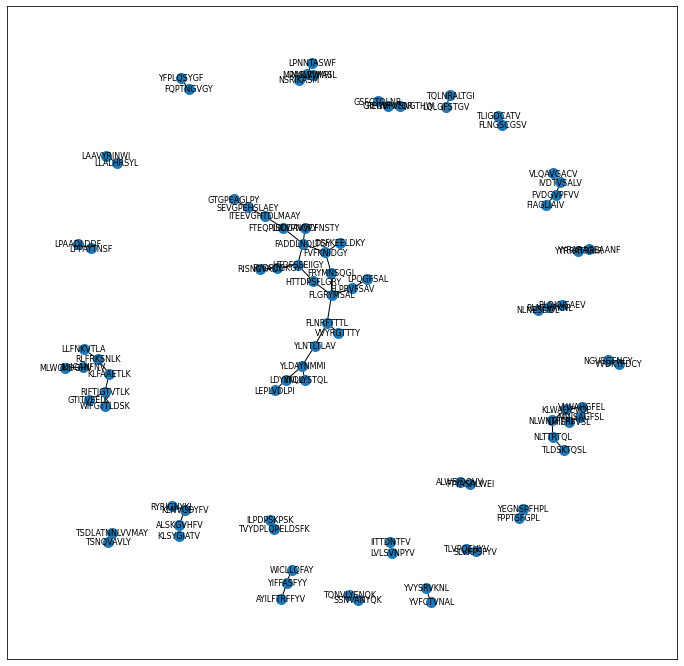

In [272]:
plt.figure(figsize=(12,12)) 
nx.draw_networkx(connnected_graph, node_size=100, font_size=8)

In [273]:
for index, component in enumerate(components):
    tcr_to_count = defaultdict(int)

    for peptide in component:
        for tcr in peptide_to_tcr[peptide]:
            tcr_to_count[tcr] += 1

    num_shared_tcrs = sum(count > 1 for count in tcr_to_count.values())

    if num_shared_tcrs > 0:
        print(f'Component {index}\n')
        print(f'Num peptides = {len(component):,}')
        print(f'Num TCRs = {len(tcr_to_count):,}')
        print(f'Num shared TCRs = {num_shared_tcrs:,}\n')

        for tcr, count in tcr_to_count.items():
            if count > 1:
                print(f'{tcr}: {count:,}')

        print('\n' + '-' * 20 + '\n')

Component 0

Num peptides = 23
Num TCRs = 14,972
Num shared TCRs = 45

CASSPLAGAYNEQFF: 2
CASSLGTGTDTQYF: 2
CASSPDYYEQYF: 2
CASSLQGYTEAFF: 2
CASSLSSYEQYF: 3
unproductive: 4
CASSLGPYNEQFF: 2
CASSSLGGNQPQHF: 2
CASSLPSSDTQYF: 2
CASSPPGLAYNEQFF: 2
CASSAGGYGYTF: 2
CASSLEQSYEQYF: 2
CASSFSSYEQYF: 2
CASSPGGTEAFF: 2
CASSLFTDTQYF: 2
CASSSGTDTQYF: 2
CASSLGGTGELFF: 2
CASSLELSYEQYF: 2
CASSLRGSEQYF: 2
CASSSDYEQYF: 2
CASSLSLGGYQETQYF: 2
CASSLTSGSTDTQYF: 2
CASSPGGYEQYF: 2
CASSQDQNTEAFF: 2
CASSDTDTQYF: 2
CASSLQGGETQYF: 2
CASSLPGSTGELFF: 2
CASSLRGYEQYF: 2
CASSSHYEQYF: 2
CASSLGNEQFF: 2
CASSLGSYNEQFF: 2
CASSYYNEQFF: 2
CASSDRDSSTDTQYF: 2
CASSLGGVEQYF: 2
CASSLPPEQYF: 2
CASSDRGYEQYF: 2
CASSLGGYEQYF: 3
CASSLSGATDTQYF: 2
CASSLGAGNEQFF: 2
CASSLADSYEQYF: 2
CASSLGSTDTQYF: 2
CASSGSSYEQYF: 2
CASSLGTANTEAFF: 2
CASSLGDEQFF: 2
CASSAYTDTQYF: 2

--------------------

Component 3

Num peptides = 4
Num TCRs = 5,397
Num shared TCRs = 5

CASSEVNEQFF: 2
CASSWGADNEQFF: 2
unproductive: 2
CASSLSESYPEKLFF: 2
CASSEVYEQYF: 2

----

In [333]:
metadata = ALL_METADATA['iedb_positive']
neg = pd.read_csv('../../data/iedb_negative.csv', sep=metadata['sep'])
# neg = clean_data(neg, tcr_col=metadata['tcr_col'], pep_col=metadata['pep_col'])
neg = neg[[all(aa in extended_iupac_protein_alphabet for aa in peptide) for peptide in neg['Description']]]
neg = neg[neg['Chain 2 CDR3 Calculated'].notna() | neg['Chain 2 CDR3 Curated'].notna()]
neg.head()

,Group Receptor ID,Receptor ID,Reference ID,Epitope ID,Description,Antigen,Organism,Response Type,Assay IDs,MHC Allele Names,...,Chain 2 CDR1 Start Curated,Chain 2 CDR1 End Curated,Chain 2 CDR1 Start Calculated,Chain 2 CDR1 End Calculated,Chain 2 CDR2 Curated,Chain 2 CDR2 Calculated,Chain 2 CDR2 Start Curated,Chain 2 CDR2 End Curated,Chain 2 CDR2 Start Calculated,Chain 2 CDR2 End Calculated
0,8493,58,1004580,16878,FLRGRAYGL,nuclear antigen EBNA-3,Human herpesvirus 4 (Epstein Barr virus),T cell,"1814845, 1814846, 1814847",HLA-B8,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
1,8493,58,1004580,144889,FLRGRFYGL,NaN,NaN,T cell,1831737,HLA-B8,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
2,8493,58,1017865,142137,EEYLQAFTY,ATP-binding cassette sub-family D member 3,Homo sapiens (human),T cell,1778798,HLA-B*44:05,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
3,8493,58,1017865,16878,FLRGRAYGL,nuclear antigen EBNA-3,Human herpesvirus 4 (Epstein Barr virus),T cell,1778796,HLA-B*08:01,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
4,8493,58,1017865,156273,EEYLKAWTF,NaN,NaN,T cell,1779482,HLA-B*44:05,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0


In [345]:
print(f'Num unique peptides = {neg["Description"].nunique():,}')
print(f'Num unique TCRs = {len(set(neg["Chain 2 CDR3 Calculated"]) | set(neg["Chain 2 CDR3 Curated"])):,}')
print(f'Num unique TCR-peptide pairs = {len(neg):,}')

Num unique peptides = 214
Num unique TCRs = 877
Num unique TCR-peptide pairs = 1,515


In [334]:
comp_peps = {peptide for component in components for peptide in component}
len(comp_peps)

46

In [335]:
set(neg['Description'].unique()) & comp_peps

{'AAGIGILTV',
 'ACDPHSGHFV',
 'ALDPHSGHFV',
 'ASNENMDAM',
 'ASNENMETM',
 'ASQKRPSQR',
 'ASQKRPSQRS'}

In [336]:
neg[neg['Description'].isin(comp_peps)]

,Group Receptor ID,Receptor ID,Reference ID,Epitope ID,Description,Antigen,Organism,Response Type,Assay IDs,MHC Allele Names,...,Chain 2 CDR1 Start Curated,Chain 2 CDR1 End Curated,Chain 2 CDR1 Start Calculated,Chain 2 CDR1 End Calculated,Chain 2 CDR2 Curated,Chain 2 CDR2 Calculated,Chain 2 CDR2 Start Curated,Chain 2 CDR2 End Curated,Chain 2 CDR2 Start Calculated,Chain 2 CDR2 End Calculated
147,619,803,1012513,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),T cell,"3791903, 3791906, 3791916, 3791919",HLA-A*02:01,...,NaN,NaN,27.0,31.0,SYGVKD,SYGVKD,NaN,NaN,49.0,54.0
148,619,803,1023541,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),T cell,"5708843, 5708846, 5708847, 5708848",HLA-A*02:01,...,NaN,NaN,27.0,31.0,SYGVKD,SYGVKD,NaN,NaN,49.0,54.0
150,619,803,1028140,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),T cell,2119223,HLA-A*02:01,...,NaN,NaN,27.0,31.0,NaN,SYGVKD,NaN,NaN,49.0,54.0
256,1243,1615,1014234,4706,ASQKRPSQR,myelin basic protein,Rattus norvegicus (Norway rat),T cell,"1660349, 1660351",H2 class II,...,NaN,NaN,25.0,29.0,NaN,SYGAGS,NaN,NaN,47.0,52.0
273,1243,1615,1029154,429015,ASQKRPSQRS,myelin basic protein,Mus musculus (mouse),T cell,2469322,H2-IAu,...,NaN,NaN,25.0,29.0,NaN,SYGAGS,NaN,NaN,47.0,52.0
492,8607,9374,1006768,4578,ASNENMDAM,Nucleoprotein,Influenza A virus (A/nt/60/1968(H3N2)) (Influe...,T cell,1514167,H2-Db,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,26468,27978,1000164,4578,ASNENMDAM,Nucleoprotein,Influenza A virus (A/nt/60/1968(H3N2)) (Influe...,T cell,"1004043, 1004057, 1004184",H2-Db,...,NaN,NaN,46.0,50.0,NaN,FRNQAP,NaN,NaN,68.0,73.0
545,26468,27978,1000367,4578,ASNENMDAM,Nucleoprotein,Influenza A virus (A/nt/60/1968(H3N2)) (Influe...,T cell,"1021721, 1021722",H2-Db,...,NaN,NaN,46.0,50.0,NaN,FRNQAP,NaN,NaN,68.0,73.0
546,26468,27978,1033878,4578,ASNENMDAM,Nucleoprotein,Influenza A virus (A/nt/60/1968(H3N2)) (Influe...,T cell,"4624489, 4988639",H2-Db,...,NaN,NaN,46.0,50.0,NaN,FRNQAP,NaN,NaN,68.0,73.0
547,26468,27978,1033878,4602,ASNENMETM,nucleoprotein,Influenza A virus,T cell,"4988636, 4988641",NaN,...,NaN,NaN,46.0,50.0,NaN,FRNQAP,NaN,NaN,68.0,73.0


In [337]:
for component in components:
    comp_tcrs = set.union(*[peptide_to_tcr[peptide] for peptide in component])
    neg_matched = neg[neg['Description'].isin(component) & (neg['Chain 2 CDR3 Calculated'].isin(comp_tcrs) | neg['Chain 2 CDR3 Curated'].isin(comp_tcrs))]
    if len(neg_matched) > 0:
        print(neg_matched)
        print('-' * 20)

     Group Receptor ID  Receptor ID  Reference ID  Epitope ID Description  \
544              26468        27978       1000164        4578   ASNENMDAM   
545              26468        27978       1000367        4578   ASNENMDAM   
546              26468        27978       1033878        4578   ASNENMDAM   
547              26468        27978       1033878        4602   ASNENMETM   

           Antigen                                           Organism  \
544  Nucleoprotein  Influenza A virus (A/nt/60/1968(H3N2)) (Influe...   
545  Nucleoprotein  Influenza A virus (A/nt/60/1968(H3N2)) (Influe...   
546  Nucleoprotein  Influenza A virus (A/nt/60/1968(H3N2)) (Influe...   
547  nucleoprotein                                  Influenza A virus   

    Response Type                  Assay IDs MHC Allele Names  ...  \
544        T cell  1004043, 1004057, 1004184            H2-Db  ...   
545        T cell           1021721, 1021722            H2-Db  ...   
546        T cell           4624489, 4

In [338]:
peptide_to_neg_tcr = defaultdict(set)

for peptide, tcr in zip(neg[metadata['pep_col']], neg[metadata['tcr_col']]):
    peptide_to_neg_tcr[peptide].add(tcr)

In [339]:
similar_pairs = [(peptides[i], peptides[j]) for i, j in zip(I, J)]

for pep_1, pep_2 in similar_pairs:
    pos_pos_tcr = peptide_to_tcr[pep_1] & peptide_to_tcr[pep_2]
    pos_neg_tcr = peptide_to_tcr[pep_1] & peptide_to_neg_tcr[pep_2]
    neg_pos_tcr = peptide_to_neg_tcr[pep_1] & peptide_to_tcr[pep_2]
    mixed_tcr = pos_neg_tcr | neg_pos_tcr

    if len(pos_pos_tcr) > 0 and len(mixed_tcr) > 0:
        print(pep_1, pep_2)
        print(pos_pos_tcr)
        print(mixed_tcr)
        print(pos_pos_tcr == mixed_tcr)
        print()

ACDPHSGHFV ALDPHSGHFV
{'ASSVVAGFNEQF'}
{'ASSVVAGFNEQF'}
True

ASNENMDAM ASNENMDTM
{'ASSSRTGGHAEQF'}
{'ASSSRTGGHAEQF'}
True

ASNENMDAM ASNENMETM
{'ASSSRTGGHAEQF'}
{'ASSSRTGGHAEQF'}
True

ASNENMDTM ASNENMETM
{'ASSSRTGGHAEQF'}
{'ASSSRTGGHAEQF'}
True

ASQKRPSQR ASQKRPSQRS
{'ASGDASGAETLY'}
{'ASGDASGAETLY'}
True



(array([121.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        113.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

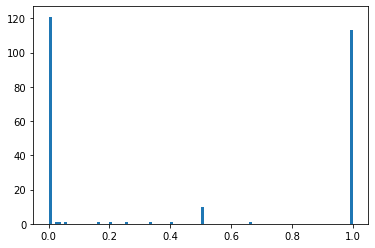

In [340]:
ious = [
    len(peptide_to_neg_tcr[pep] & peptide_to_tcr[pep]) / len(peptide_to_neg_tcr[pep] | peptide_to_tcr[pep])
    for pep in peptide_to_neg_tcr
]
_ = plt.hist(ious, bins=100)